# Bivariate analysis


The objective of this notebook is to analyze each variable vs. the target to understand patterns, associations, and potential causal relationships between the variables.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import scatter_plot
import numpy as np
import category_encoders as ce
import os

base_directory = 'images/images_bivar_analysis'

os.makedirs(base_directory, exist_ok=True)

In [2]:
data = pd.read_parquet('../data/silver/df_fraud_univar.parquet', engine= 'fastparquet')
data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,no_fraud,1,1.000-10.000
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,no_fraud,1,1.000-10.000
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,fraud,1,0-1.000
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,fraud,1,0-1.000
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,no_fraud,1,10.000-100.000


## step & day_of_month vs. isFraud

- hay un valor extremo en 339 creo
- explicar los graficos de frequency
- estudiar 339 con fraud y no fraud
- hacer merge de var_step dentro de esta notebook
- contestar preguntas del univar

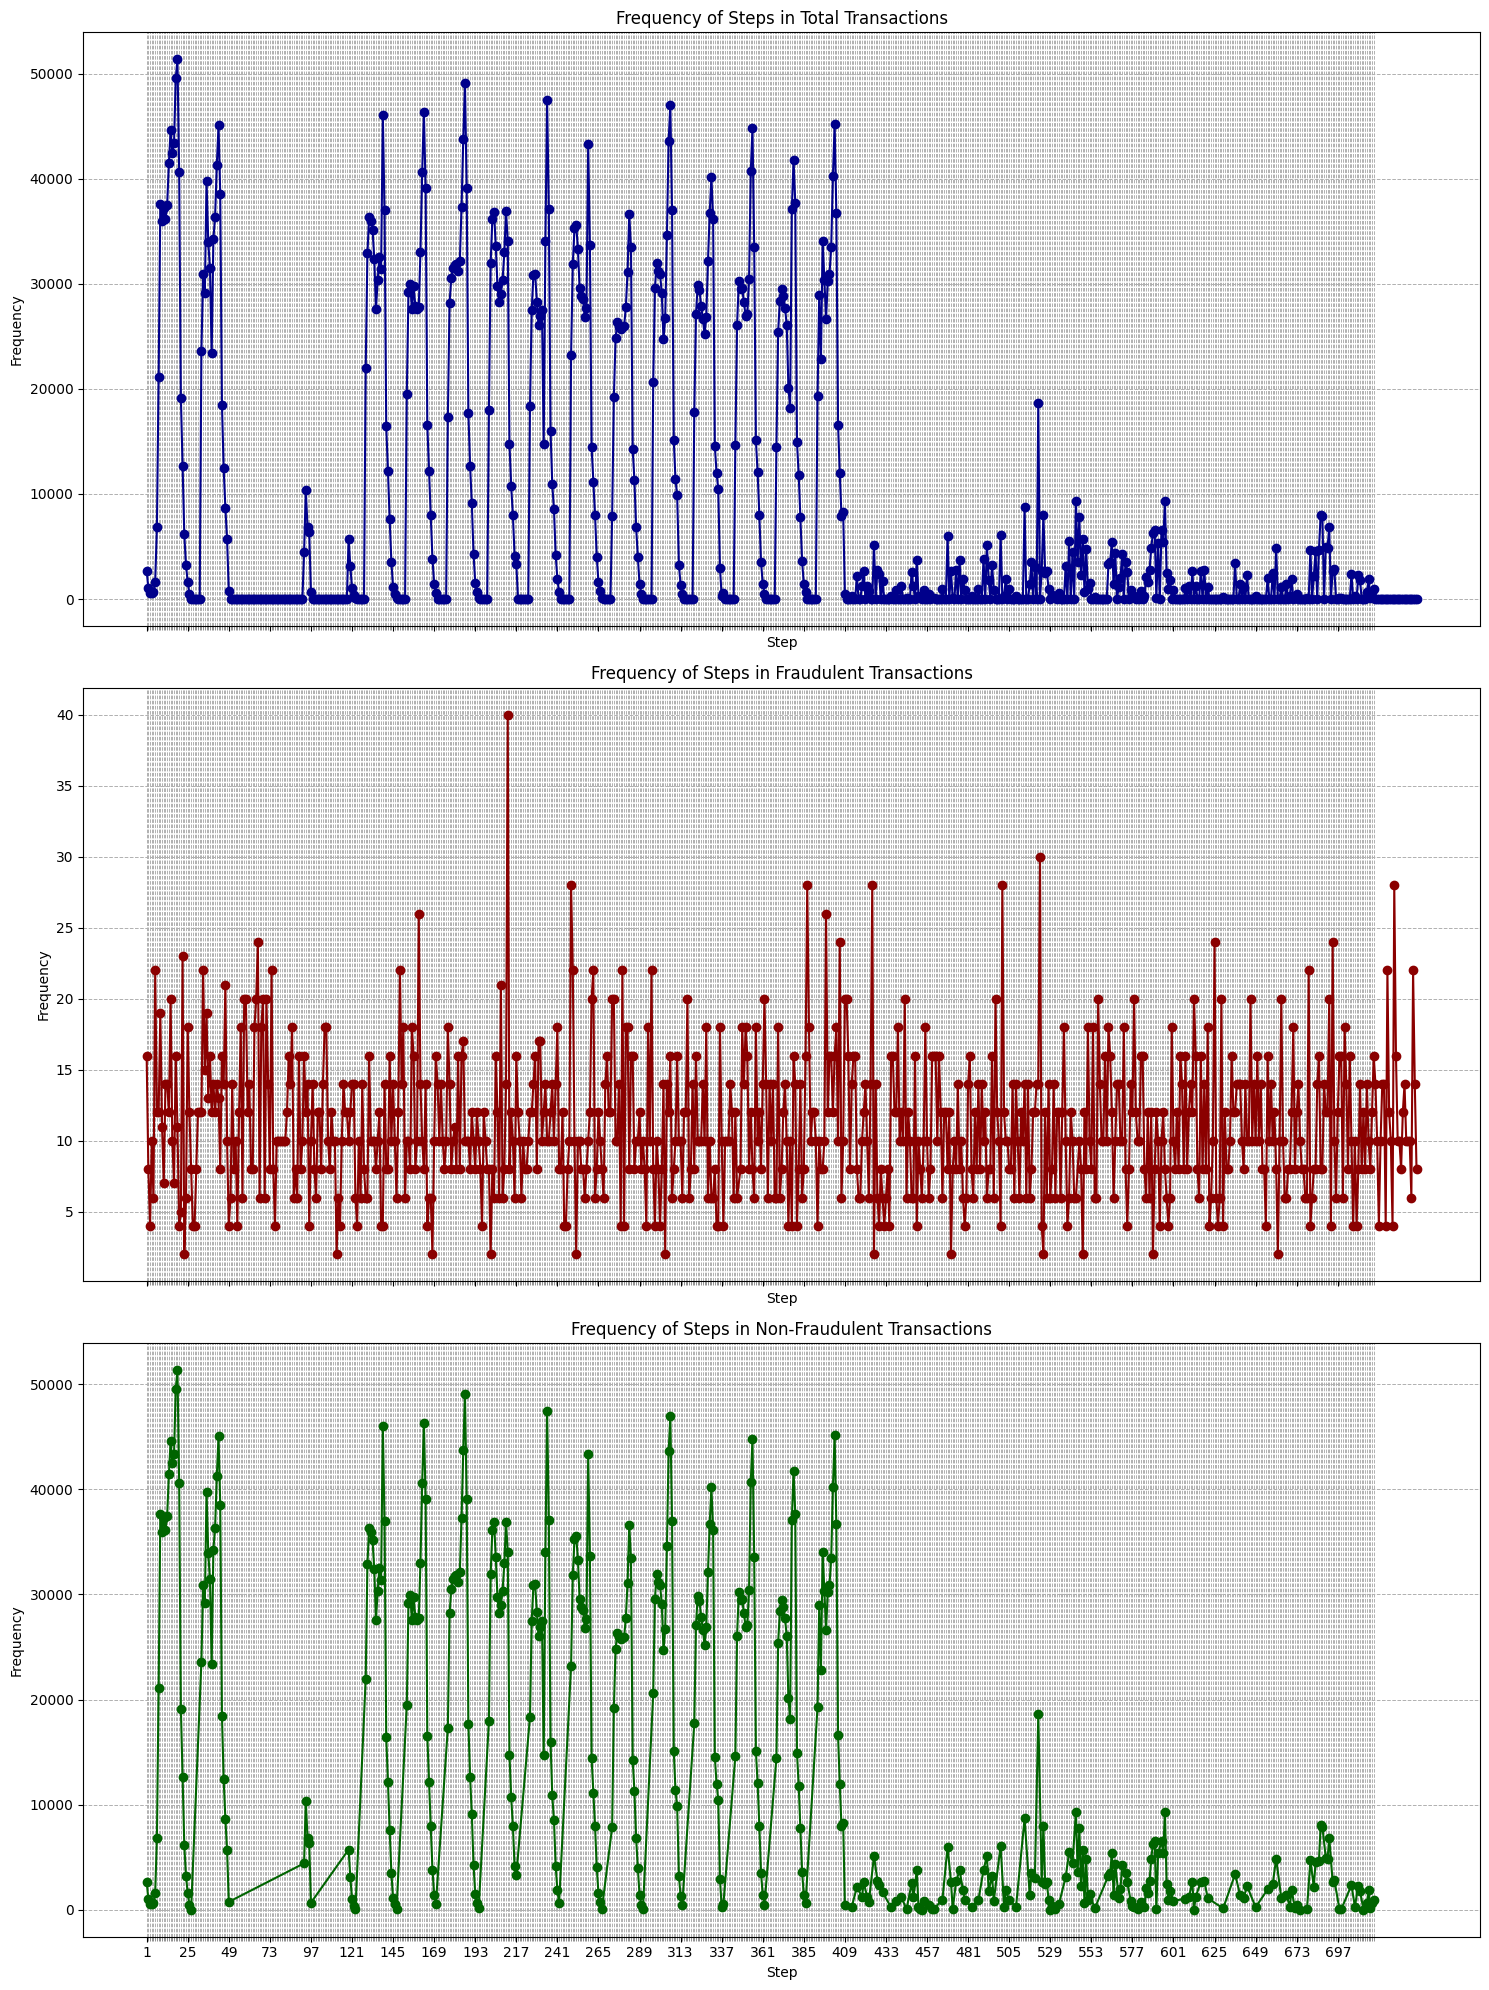

In [34]:
total_value_counts = data['step'].value_counts().sort_index()
fraud_value_counts = data[data['isFraud'] == 'fraud']['step'].value_counts().sort_index()
non_fraud_value_counts = data[data['isFraud'] == 'no_fraud']['step'].value_counts().sort_index()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 20), sharex=True)

titles = [
    "Frequency of Steps in Total Transactions", 
    "Frequency of Steps in Fraudulent Transactions", 
    "Frequency of Steps in Non-Fraudulent Transactions"
]
colors = ['#00008B', '#8B0000', '#006400']
counts_list = [total_value_counts, fraud_value_counts, non_fraud_value_counts]

for ax, counts, title, color in zip(axes, counts_list, titles, colors):
    ax.plot(counts.index, counts, marker='o', color=color, linestyle='-', markersize=6)
    ax.set_title(title)
    ax.set_xlabel("Step")
    ax.set_ylabel("Frequency")
    ax.grid(True, which='both', linestyle='--', linewidth=0.7)
    ax.set_xticks(np.arange(min(counts.index), max(counts.index) + 1, 24)) 
    ax.set_xticks(np.arange(min(counts.index), max(counts.index) + 1, 1), minor=True)  
    ax.tick_params(axis='x', which='minor', length=3, color='grey')

plt.tight_layout()
plt.show()


Observations:

For context, 1 step represents 1 hour. The total range of hour data is equivalent to a month. 

There is a clear pattern that differentiates the behaviour between the fraudulent and the non-fraudulent transactions.

There is also a step with very high frequency around the step 240.

Non-fraudulent transactions happen inside defined step ranges and slow down when the step is a bit higher than 400 (15 days aprox). This behaviour makes sense since people get their salaries at the beginning of the month. The is a gap between the first 48 and 120 hours. It would be interesting to get more information about the month, year, country from where the transaction was sent/received. Was it a public holiday? 

Fraudulent transactions stay constant along the step range. That means fraudsters behaviour stays constant all over the month. 

Fraudsters usually take very short time to process the transaction so it would be also nice to obtain data about the amount of time spent on the merchants website, the time used by the client to confirm the transaction (short times can indicate that a bot is actually using the platform), etc.

---

What is happening in the very frequent step? How is the relationship between that step and fraud?

In [4]:
contingency_table = pd.crosstab(data['step'], data['isFraud'])
contingency_table['total'] = contingency_table['fraud'] + contingency_table['no_fraud']
contingency_table['fraud_proportion'] = (contingency_table['fraud'] / contingency_table['total']) * 100

contingency_table.loc[(contingency_table.index > 220) & (contingency_table.index < 250)]

isFraud,fraud,no_fraud,total,fraud_proportion
step,,,,
221,10,0,10,100.000000
222,8,0,8,100.000000
223,8,0,8,100.000000
224,10,0,10,100.000000
225,12,18354,18366,0.065338
226,12,27510,27522,0.043601
227,14,30857,30871,0.045350
228,16,30949,30965,0.051671
229,8,28296,28304,0.028265


Observations:

- The highly frequent step is the step 239.
- As the plot shows, that step is much more frequent than any other. 

Step 239 = 9 days + 23h. Time to ask what happened here from a business perspective. Why so many people are purchasing that day? Why at that time? 

Observations:

- There are other steps with a high ratio even though the amount of transactions per step can have less. Further analysis related to the day of the week, the hour of the day or the gap of days between high ratio steps could be studied here.

Taking into consideration that these are proportions, not total values. 

In [5]:
contingency_table = pd.crosstab(data['day_of_month'], data['isFraud'])
contingency_table['total'] = contingency_table['fraud'] + contingency_table['no_fraud']
contingency_table['fraud_proportion'] = (contingency_table['fraud'] / contingency_table['total']) * 100
contingency_table

isFraud,fraud,no_fraud,total,fraud_proportion
day_of_month,,,,
1,271,573984,574255,0.047192
2,309,454929,455238,0.067877
3,310,760,1070,28.971963
4,262,27978,28240,0.927762
5,252,9537,9789,2.574318
6,228,440777,441005,0.051700
7,272,420311,420583,0.064672
8,278,449359,449637,0.061828
9,255,417664,417919,0.061017


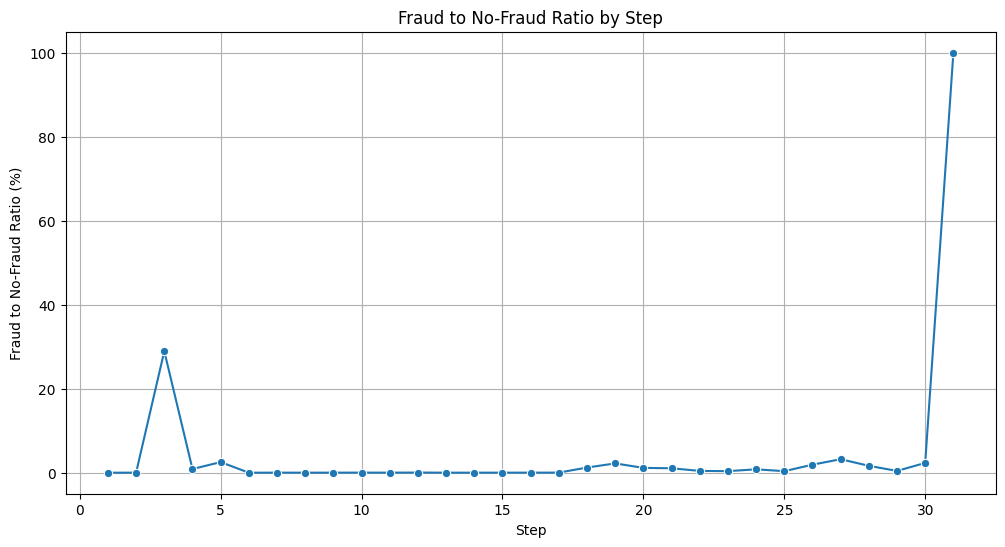

In [6]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=contingency_table, x='day_of_month', y='fraud_proportion', marker='o')
plt.title('Fraud to No-Fraud Ratio by Step')
plt.xlabel('Step')
plt.ylabel('Fraud to No-Fraud Ratio (%)')
plt.grid(True)
plt.show()

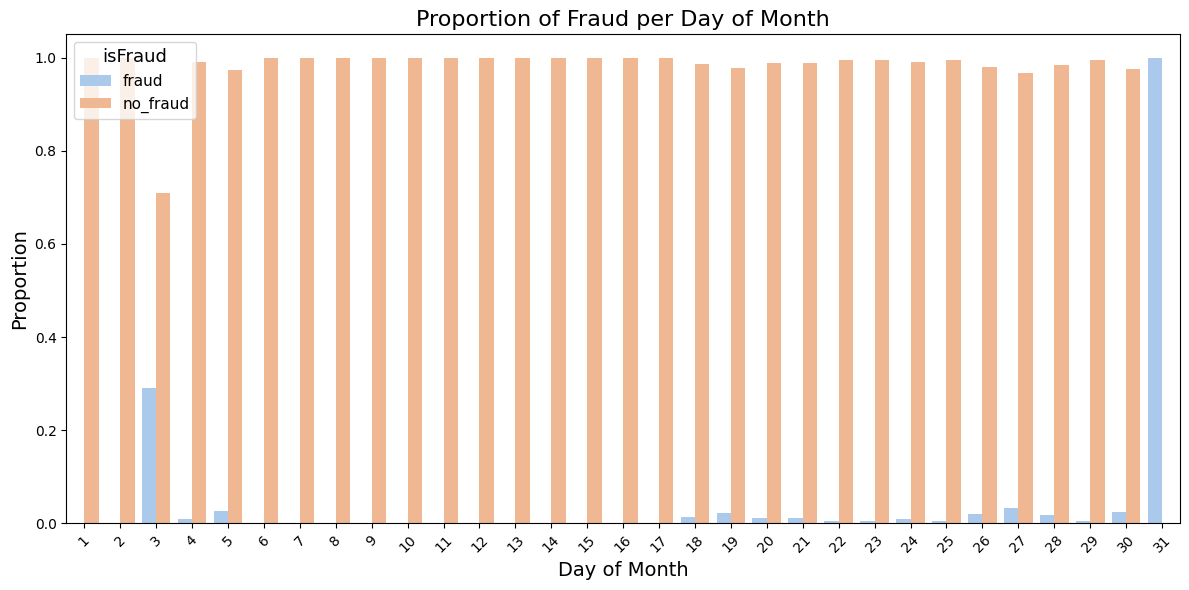

In [7]:
df_grouped = data.groupby(['day_of_month', 'isFraud'], observed=False).size().reset_index(name='count')
df_grouped['proportion'] = df_grouped.groupby('day_of_month')['count'].transform(lambda x: x / x.sum())

palette = sns.color_palette("pastel", n_colors=2)

# Crear el gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_month', y='proportion', hue='isFraud', data=df_grouped, palette=palette)

plt.title('Proportion of Fraud per Day of Month', fontsize=16)
plt.xlabel('Day of Month', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45)  # Rotar etiquetas en el eje x para mejor legibilidad
plt.legend(title='isFraud', title_fontsize='13', fontsize='11')
plt.tight_layout()  # Ajustar diseño para que no se corten elementos
plt.show()

Observations:

- The last day of the month has only fraudulent transactions. Curious, right? I would need more info about the context but it looks like it's a coincidence.

Besides that I don't see any clear pattern.

## type vs. isFraud

In [8]:
data.dtypes

step                 int16
type              category
amount             float32
nameOrig          category
oldbalanceOrig     float32
newbalanceOrig     float32
nameDest          category
oldbalanceDest     float32
newbalanceDest     float32
isFraud           category
day_of_month          int8
amount_range      category
dtype: object

In [9]:
contingency_table = pd.crosstab(data['type'], data['isFraud'])
contingency_table

isFraud,fraud,no_fraud
type,,
CASH_IN,0,1399284
CASH_OUT,4116,2233384
DEBIT,0,41432
PAYMENT,0,2151495
TRANSFER,4097,528812


Observations:

The only types that have fraudulent transactions are CASH_OUT and TRANSFER and as we saw in the univariate analysis they are substantially less common

-------

## amount vs. isFraud

In [10]:
data.query('amount == 0')

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.000000e+00,0.000000e+00,fraud,9,0-1.000
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.000000e+00,0.000000e+00,fraud,11,0-1.000
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,5.385476e+05,5.385476e+05,fraud,12,0-1.000
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7.970766e+06,7.970766e+06,fraud,17,0-1.000
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,7.675990e+04,7.675990e+04,fraud,18,0-1.000
5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2.921531e+06,2.921531e+06,fraud,18,0-1.000
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,2.302897e+05,2.302897e+05,fraud,24,0-1.000
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1.328473e+06,1.328473e+06,fraud,25,0-1.000
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.000000e+00,0.000000e+00,fraud,26,0-1.000
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.000000e+00,0.000000e+00,fraud,27,0-1.000


Observations:

Withrawals with amount = 0 are fraudulent, none of them is repeated and they have been used to try to withdraw money. We could analyze the origin and destination users and see their behaviour. One example could be using the postal code, the IP data, the account age, etc. to find hidden patterns.


----
Is the type of small amount transactions (less than 40k) found in the univariate analysis related to fraudulent behaviour? 


In [11]:
small_amounts = data.query('amount < 40000')
small_amounts

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
0,1,PAYMENT,9839.639648,C1231006815,170136.000000,160296.359375,M1979787155,0.000000,0.000000,no_fraud,1,1.000-10.000
1,1,PAYMENT,1864.280029,C1666544295,21249.000000,19384.720703,M2044282225,0.000000,0.000000,no_fraud,1,1.000-10.000
2,1,TRANSFER,181.000000,C1305486145,181.000000,0.000000,C553264065,0.000000,0.000000,fraud,1,0-1.000
3,1,CASH_OUT,181.000000,C840083671,181.000000,0.000000,C38997010,21182.000000,0.000000,fraud,1,0-1.000
4,1,PAYMENT,11668.139648,C2048537720,41554.000000,29885.859375,M1230701703,0.000000,0.000000,no_fraud,1,10.000-100.000
...,...,...,...,...,...,...,...,...,...,...,...,...
6362512,734,TRANSFER,23912.199219,C1790385148,23912.199219,0.000000,C1671472479,0.000000,0.000000,fraud,31,10.000-100.000
6362513,734,CASH_OUT,23912.199219,C4748745,23912.199219,0.000000,C1953200125,338951.656250,362863.843750,fraud,31,10.000-100.000
6362566,739,TRANSFER,8116.529785,C2072430566,8116.529785,0.000000,C765215468,0.000000,0.000000,fraud,31,1.000-10.000
6362567,739,CASH_OUT,8116.529785,C564539602,8116.529785,0.000000,C1935865739,7638.259766,15754.790039,fraud,31,1.000-10.000


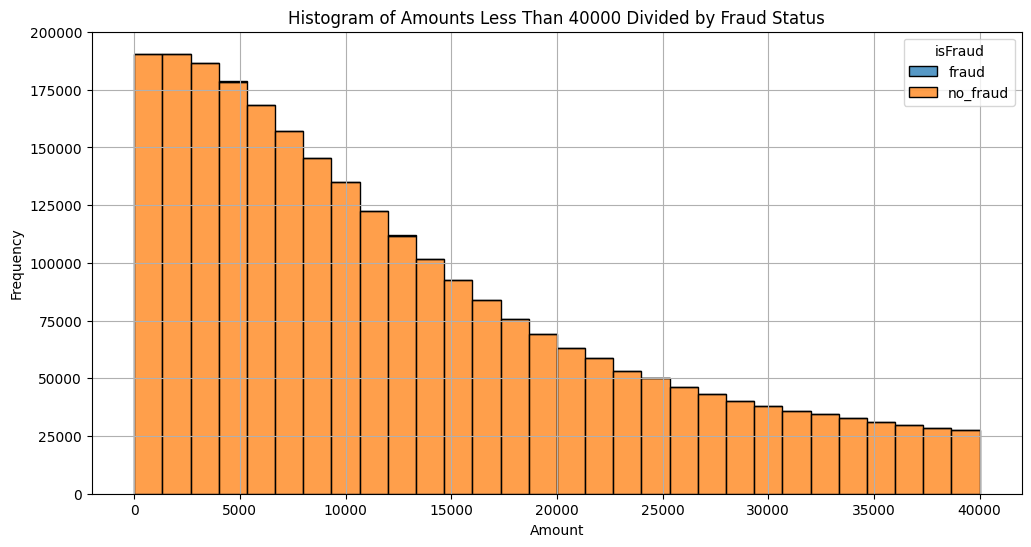

In [12]:
plt.figure(figsize=(12, 6))
sns.histplot(data=small_amounts, x='amount', hue='isFraud', multiple='stack', bins=30)
plt.title('Histogram of Amounts Less Than 40000 Divided by Fraud Status')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [13]:
more_4k_amounts = data.query('400000 < amount')

In [14]:
more_4k_amounts['amount'].max()

92445520.0

In [15]:
more_4k_amounts.describe()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,day_of_month
count,529395.000000,5.293950e+05,5.293950e+05,5.293950e+05,5.293950e+05,5.293950e+05,529395.000000
mean,241.455271,1.053048e+06,5.432357e+05,5.600171e+05,2.682917e+06,3.688400e+06,10.443979
std,143.277458,1.851378e+06,2.335068e+06,2.399890e+06,6.162661e+06,7.484122e+06,5.961120
min,1.000000,4.000003e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
25%,143.000000,4.613276e+05,0.000000e+00,0.000000e+00,2.156425e+05,8.707405e+05,6.000000
50%,237.000000,5.790648e+05,5.440000e+03,0.000000e+00,1.140164e+06,1.858771e+06,10.000000
75%,345.000000,9.903503e+05,5.771721e+04,0.000000e+00,2.912671e+06,3.943054e+06,15.000000
max,743.000000,9.244552e+07,5.958504e+07,4.958504e+07,3.553805e+08,3.560159e+08,31.000000


In [16]:
more_4k_amounts

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
85,1,TRANSFER,1.505626e+06,C926859124,0.000,0.0,C665576141,2.903100e+04,5.515764e+06,no_fraud,1,1.000.000-10.000.000
86,1,TRANSFER,5.540270e+05,C1603696865,0.000,0.0,C766572210,5.792856e+05,0.000000e+00,no_fraud,1,100.000-1.000.000
88,1,TRANSFER,7.615074e+05,C412788346,0.000,0.0,C1590550415,1.280036e+06,1.916920e+07,no_fraud,1,100.000-1.000.000
89,1,TRANSFER,1.429052e+06,C1520267010,0.000,0.0,C1590550415,2.041544e+06,1.916920e+07,no_fraud,1,1.000.000-10.000.000
93,1,TRANSFER,5.838484e+05,C1839168128,0.000,0.0,C1286084959,6.677780e+05,2.107778e+06,no_fraud,1,100.000-1.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...
6362613,743,CASH_OUT,1.258819e+06,C1436118706,1258818.875,0.0,C1240760502,5.034645e+05,1.762283e+06,fraud,31,1.000.000-10.000.000
6362616,743,TRANSFER,6.311410e+06,C1529008245,6311409.500,0.0,C1881841831,0.000000e+00,0.000000e+00,fraud,31,1.000.000-10.000.000
6362617,743,CASH_OUT,6.311410e+06,C1162922333,6311409.500,0.0,C1365125890,6.848884e+04,6.379898e+06,fraud,31,1.000.000-10.000.000
6362618,743,TRANSFER,8.500025e+05,C1685995037,850002.500,0.0,C2080388513,0.000000e+00,0.000000e+00,fraud,31,100.000-1.000.000


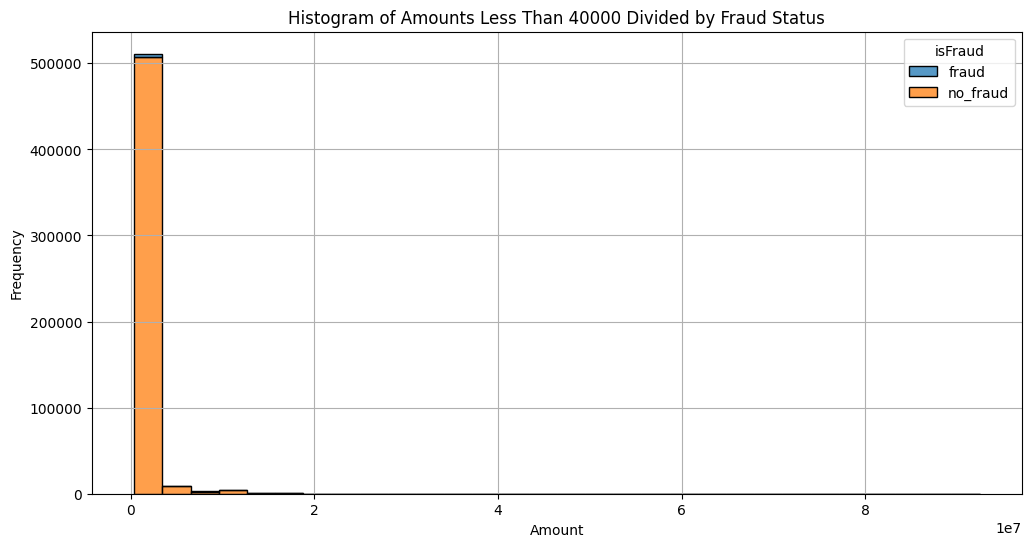

In [17]:
plt.figure(figsize=(12, 6))
sns.histplot(data=more_4k_amounts, x='amount', hue='isFraud', multiple='stack', bins=30)
plt.title('Histogram of Amounts Less Than 40000 Divided by Fraud Status')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [18]:
is_cached = False
try:
    %store -r repeated_amounts
    is_cached = True
except NameError:
    is_cached = False

if is_cached:
    print("The DataFrame is already stored in cache")
else:
    print("DataFrame not found. Calculating...")

    repeated_rows = data[data.duplicated('amount', keep=False) & (data['amount'] != 0)]

    repeated_amounts = (repeated_rows.groupby('amount')
                    .agg(count_is_not_Fraud=('isFraud', lambda x: (x == 'no_fraud').sum()),
                            count_isFraud=('isFraud', lambda x: (x == 'fraud').sum()),
                            percentage_is_not_Fraud=('isFraud', lambda x: round((x == 'no_fraud').mean() * 100, 2)),
                            percentage_isFraud=('isFraud', lambda x: round((x == 'fraud').mean() * 100, 2)))
                    .reset_index())

    %store repeated_amounts


The DataFrame is already stored in cache


In [19]:
repeated_amounts[(repeated_amounts['amount'] > 60) & (repeated_amounts['amount'] < 80)]

,amount,count_isFraud_0,count_isFraud_1,percentage_is_not_Fraud,percentage_isFraud
2395,60.020000,4,0,100.0,0.0
2396,60.029999,4,0,100.0,0.0
2397,60.049999,2,0,100.0,0.0
2398,60.080002,2,0,100.0,0.0
2399,60.139999,2,0,100.0,0.0
...,...,...,...,...,...
3209,79.889999,2,0,100.0,0.0
3210,79.910004,2,0,100.0,0.0
3211,79.970001,2,0,100.0,0.0
3212,79.980003,2,0,100.0,0.0


In [20]:
data.query('amount == 38.439999')

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range
527518,20,PAYMENT,38.439999,C1742594262,1.173970e+03,1.135530e+03,M1504067698,0.000,0.0000,no_fraud,1,0-1.000
1646544,157,CASH_IN,38.439999,C106088958,1.128239e+07,1.128243e+07,C2117215775,776372.875,776334.4375,no_fraud,7,0-1.000
4778162,335,PAYMENT,38.439999,C1907490030,3.090740e+05,3.090356e+05,M1842921904,0.000,0.0000,no_fraud,14,0-1.000


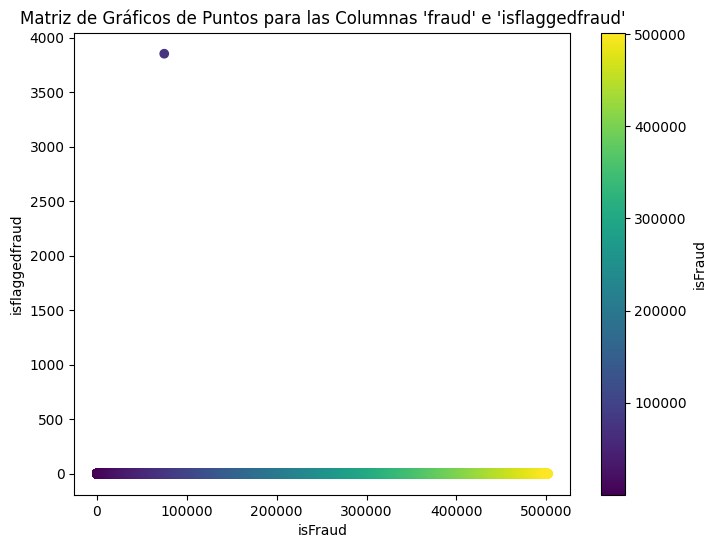

In [21]:
scatter_plot(repeated_amounts['amount'], repeated_amounts['count_isFraud_1'])

In [22]:
integer_rows = data[data['amount'] == data['amount'].astype(int)]

# Agrupar por 'amount' y calcular los porcentajes de 'isFraud'
integer_amounts = integer_rows.groupby('amount').apply(lambda x: pd.Series({
    'count': x.shape[0],
    'percentage_isFraud_0': (x['isFraud'] == 0).mean() * 100,
    'percentage_isFraud_1': (x['isFraud'] == 1).mean() * 100
})).reset_index()

/tmp/ipykernel_352392/1393644676.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  integer_amounts = integer_rows.groupby('amount').apply(lambda x: pd.Series({


## nameOrig vs. isFraud

From the univariate analysis we found that there were many transactions with the same amount. Let's check them

## oldbalanceOrig vs. isFraud

## newbalanceOrig vs. isFraud

---

### Correlation

In [23]:
numerical_cols = data.select_dtypes(include=['float32', 'int16']).columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
numerical_cols


Index(['step', 'amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')

In [24]:
if numerical_cols.empty:
    raise ValueError("No se encontraron columnas numéricas en el dataset.")
if categorical_cols.empty:
    raise ValueError("No se encontraron columnas categóricas en el dataset.")

# Aplicar Target Encoding a las variables categóricas
encoder = ce.TargetEncoder(cols=categorical_cols)

# Usar la primera columna numérica como target para la codificación
target_col = numerical_cols[0]
df_encoded = encoder.fit_transform(data, data[target_col])

# Calcular la matriz de correlación
correlacion = df_encoded.corr()



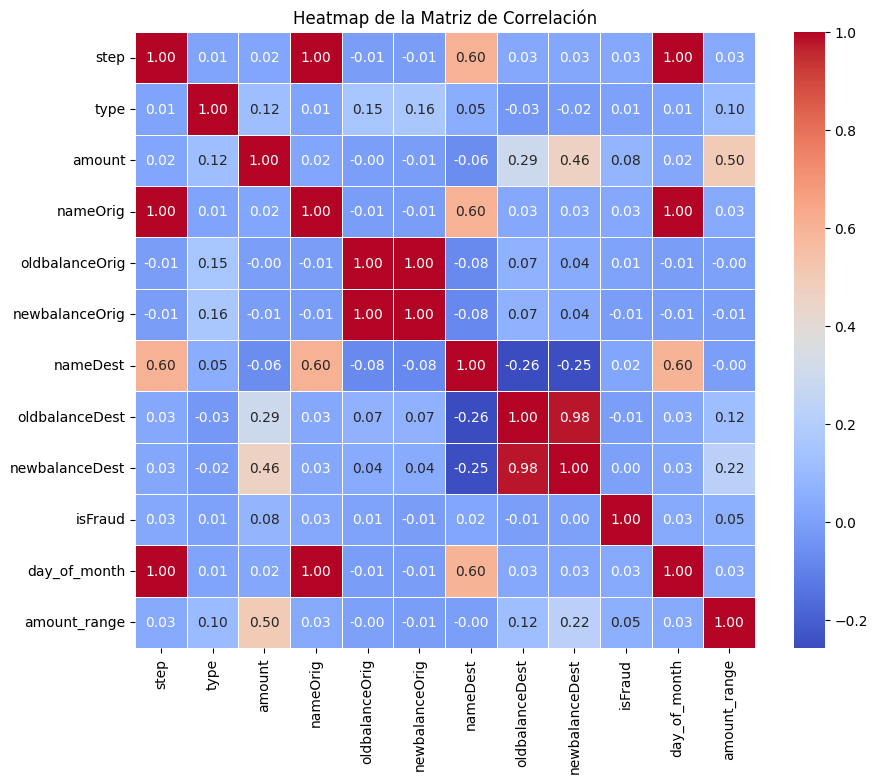

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap de la Matriz de Correlación')
plt.show()

Variables a eliminar por alta correlación: {'nameOrig', 'day_of_month', 'newbalanceDest', 'newbalanceOrig'}


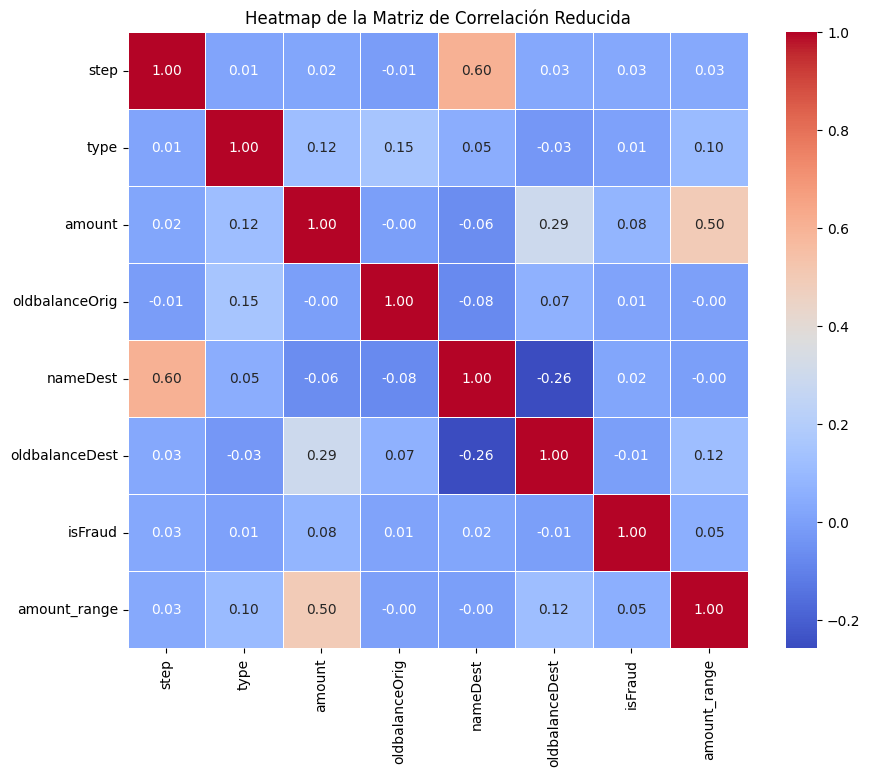

In [26]:
# Eliminar variables altamente correlacionadas
# Establecer el umbral de correlación
umbral = 0.9

# Encontrar las parejas de variables con alta correlación
correlacion_alta = [(col1, col2) for col1 in correlacion.columns for col2 in correlacion.columns 
                    if col1 != col2 and abs(correlacion.loc[col1, col2]) > umbral]

# Crear una lista de variables a eliminar
variables_a_eliminar = set()
for col1, col2 in correlacion_alta:
    if col1 not in variables_a_eliminar and col2 not in variables_a_eliminar:
        variables_a_eliminar.add(col2)

print(f"Variables a eliminar por alta correlación: {variables_a_eliminar}")

# Eliminar las variables del dataframe
df_reducido = df_encoded.drop(columns=variables_a_eliminar)

# Calcular y mostrar el nuevo heatmap de la matriz de correlación reducida
correlacion_reducida = df_reducido.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion_reducida, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap de la Matriz de Correlación Reducida')
plt.show()

In [27]:
df_reducido.to_parquet('../data/processed/df_final.parquet', engine= 'fastparquet')

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/df_final.parquet'